In [ ]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import yfinance as yf

Tensorflow version: 2.15.0


<ipython-input-1-d50ec634a13b>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
start_date = "2000-08-23"
end_date = "2024-04-01"

exxon = yf.download('XOM',start=start_date,end=end_date)

exxon


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-08-23,41.875000,42.375000,41.875000,42.250000,20.104786,9290600
2000-08-24,41.687500,41.687500,41.250000,41.468750,19.733030,11205000
2000-08-25,41.500000,41.843750,41.218750,41.468750,19.733030,6401800
2000-08-28,41.343750,41.906250,41.281250,41.406250,19.703285,5888000
2000-08-29,41.406250,41.500000,41.125000,41.257812,19.632648,6416800
...,...,...,...,...,...,...
2024-03-22,113.480003,113.690002,112.820000,113.489998,113.489998,14695400
2024-03-25,113.830002,115.779999,113.830002,114.650002,114.650002,14011700
2024-03-26,114.660004,114.980003,113.410004,113.790001,113.790001,13152300


In [ ]:
exxon['Volume'].replace(to_replace=0, method='ffill', inplace=True)
exxon.sort_values('Date', inplace=True)


exxon[['Open', 'High', 'Low', 'Close', 'Volume']] = exxon[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean()

# Drop all rows with NaN values
exxon.dropna(how='any', axis=0, inplace=True)
exxon.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-09-19,41.822187,42.164687,41.573437,41.877891,20.937527,10372200.0
2000-09-20,41.982500,42.348438,41.726250,42.046016,20.580645,10876428.0
2000-09-21,42.157812,42.548437,41.890625,42.230703,20.536037,11486880.0
2000-09-22,42.350938,42.764063,42.069375,42.427578,20.580645,12203782.0
2000-09-25,42.553437,42.973438,42.247500,42.618594,20.428213,12868170.0
2000-09-26,42.741875,43.176563,42.420938,42.799297,20.610386,13404000.0
2000-09-27,42.920000,43.384063,42.586562,42.980703,21.234938,13914556.0
2000-09-28,43.100625,43.595938,42.752812,43.161953,21.208916,14500420.0
2000-09-29,43.269375,43.770000,42.904688,43.316953,21.201477,14796372.0


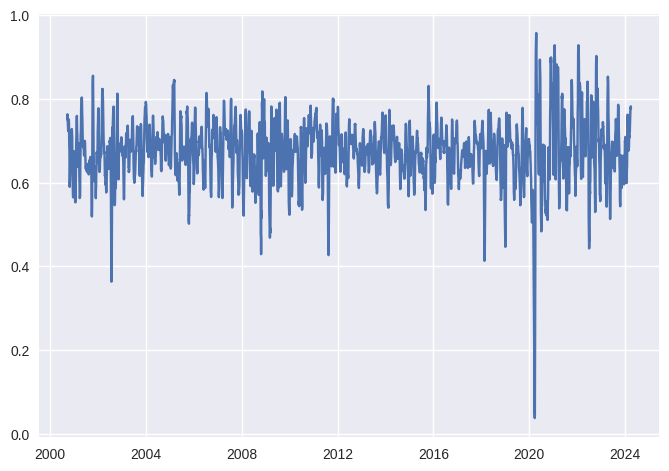

In [ ]:
plt.plot(exxon['Close'])

In [ ]:
exxon['Open'] = exxon['Open'].pct_change() # Create arithmetic returns column
exxon['High'] = exxon['High'].pct_change() # Create arithmetic returns column
exxon['Low'] = exxon['Low'].pct_change() # Create arithmetic returns column
exxon['Close'] = exxon['Close'].pct_change() # Create arithmetic returns column
exxon['Volume'] = exxon['Volume'].pct_change()

exxon.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(exxon[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(exxon[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
exxon['Open'] = (exxon['Open'] - min_return) / (max_return - min_return)
exxon['High'] = (exxon['High'] - min_return) / (max_return - min_return)
exxon['Low'] = (exxon['Low'] - min_return) / (max_return - min_return)
exxon['Close'] = (exxon['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = exxon['Volume'].min(axis=0)
max_volume = exxon['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
exxon['Volume'] = (exxon['Volume'] - min_volume) / (max_volume - min_volume)


In [ ]:
times = sorted(exxon.index.values)
last_10pct = sorted(exxon.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(exxon.index.values)[-int(0.2*len(times))] # Last 20% of series

# Split train, valid and test
df_train = exxon[(exxon.index < last_20pct)]  # Training data are 80% of total data
df_val = exxon[(exxon.index >= last_20pct) & (exxon.index < last_10pct)]
df_test = exxon[(exxon.index >= last_10pct)]

# # Remove date column
df_train.drop(columns=['Adj Close'], inplace=True)
df_val.drop(columns=['Adj Close'], inplace=True)
df_test.drop(columns=['Adj Close'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()


Training data shape: (4734, 5)
Validation data shape: (592, 5)
Test data shape: (591, 5)


<ipython-input-13-5b610e9a431f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=['Adj Close'], inplace=True)
<ipython-input-13-5b610e9a431f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.drop(columns=['Adj Close'], inplace=True)
<ipython-input-13-5b610e9a431f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=['Adj Close'], inplace=True)


,Open,High,Low,Close,Volume
Date,,,,,
2000-09-20,0.746652,0.756926,0.743569,0.750205,0.702740
2000-09-21,0.753361,0.764068,0.748731,0.757603,0.746945
2000-09-22,0.761294,0.770824,0.755147,0.762877,0.783923
2000-09-25,0.765219,0.767462,0.754501,0.759750,0.737031
2000-09-26,0.758303,0.764147,0.751979,0.754617,0.661708


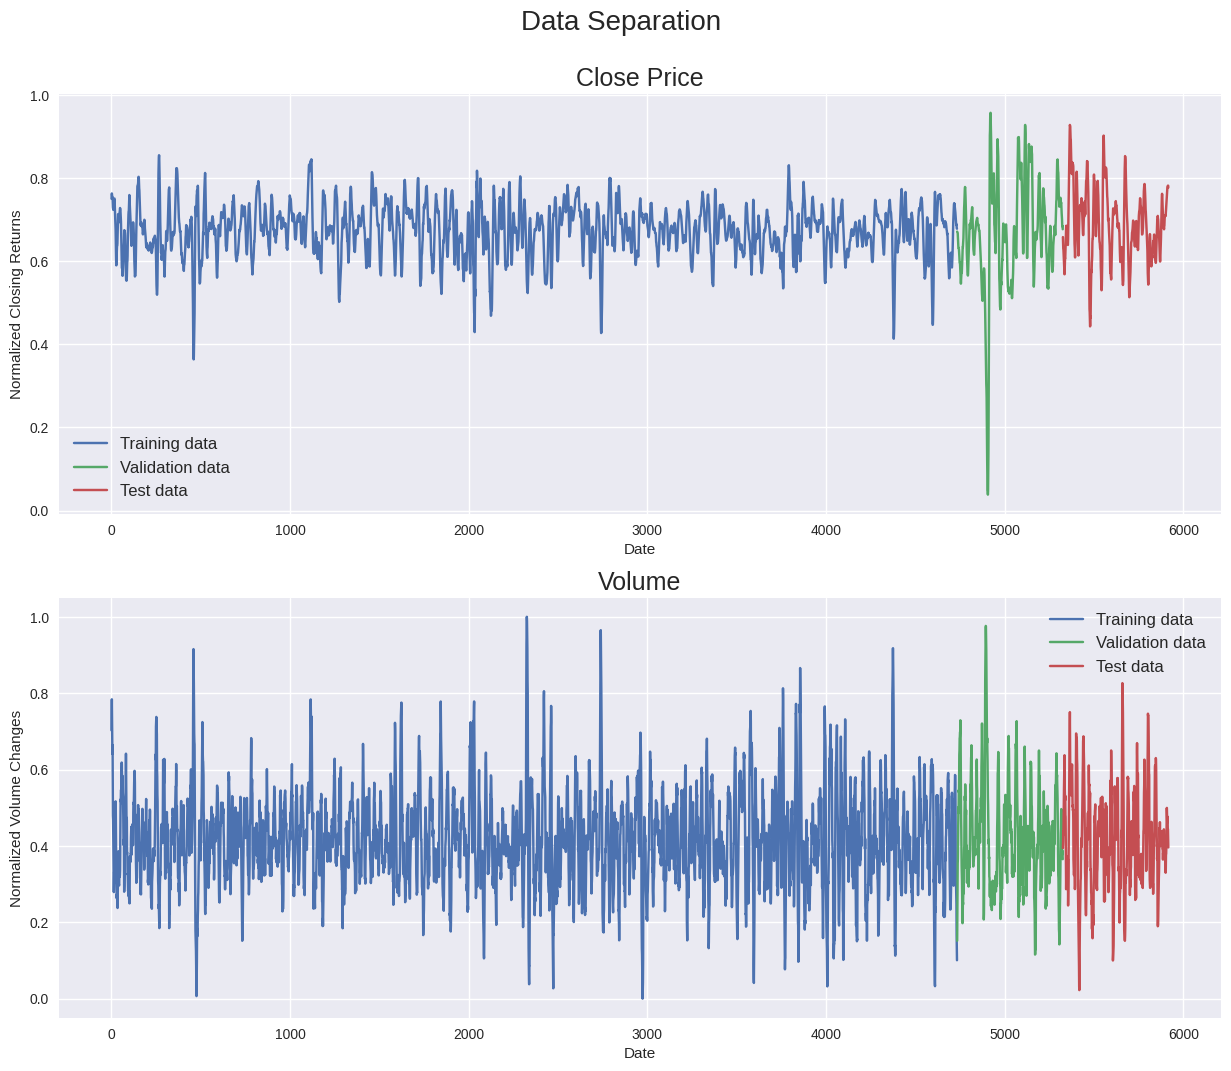

In [ ]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

In [ ]:
seq_len = 60

In [ ]:
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (4674, 60, 5) (4674,)
Validation set shape (532, 60, 5) (532,)
Testing set shape (531, 60, 5) (531,)


In [ ]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    # initiate 4 matrices, 2 for ω and 2 forφ since we need aω and φ matrix for
    # both non-periodical (linear) and the periodical (sin) features.
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  # 'x' shape is (batch_size, seq_len, 5) → (32, 128, 5). The batch_size defines how
  # many stock price sequences we want to feed into the model/layer at once. The seq_len
  # parameter determines the length of a single stock price sequence. Lastly, the
  # number 5 is derived from the fact that we have 5 features of the daily IBM stock
  # recording (Open price, High price, Low price, Close price, Volume)
  def call(self, x):
    '''Calculate linear and periodic time features'''

    # Exclude Volume and average across the Open, High, Low, and Close prices, resulting
    # in the shape (batch_size, seq_len)
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)

    # calculate the non-periodic (linear) time feature and expand the dimension by 1 again ie. (batch_size, seq_len, 1)
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

    # repeat for the periodic time feature, also resulting in the same matrix shape. (batch_size, seq_len, 1)
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)

    # concatenate the linear and periodic time feature. (batch_size, seq_len, 2)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [ ]:
d_k = 120
d_v = 120
n_heads = 12
ff_dim = 120


In [ ]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

    self.key = Dense(self.d_k,
                     input_shape=input_shape,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='glorot_uniform')

    self.value = Dense(self.d_v,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)

    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
    self.linear = Dense(input_shape[0][-1],
                        input_shape=input_shape,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


In [ ]:
model = create_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60, 5)]              0         []                            
                                                                                                  
 time2_vector (Time2Vector)  (None, 60, 2)                240       ['input_1[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 60, 7)                0         ['input_1[0][0]',             
                                                                     'time2_vector[0][0]']        
                                                                                                  
 transformer_encoder (Trans  (None, 60, 7)                46482     ['concatenate[0][0]',     

In [ ]:
batch_size = 32

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5',
                                              monitor='val_loss',
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=35,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

Epoch 1/35
147/147 [==============================] - ETA: 0s - loss: 0.0509 - mae: 0.1393 - mape: 20.8450
Epoch 1: val_loss improved from inf to 0.02009, saving model to Transformer+TimeEmbedding.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/147 [==============================] - 151s 631ms/step - loss: 0.0509 - mae: 0.1393 - mape: 20.8450 - val_loss: 0.0201 - val_mae: 0.1002 - val_mape: 30.6469
Epoch 2/35
147/147 [==============================] - ETA: 0s - loss: 0.0066 - mae: 0.0643 - mape: 9.7897
Epoch 2: val_loss improved from 0.02009 to 0.01987, saving model to Transformer+TimeEmbedding.hdf5
147/147 [==============================] - 84s 571ms/step - loss: 0.0066 - mae: 0.0643 - mape: 9.7897 - val_loss: 0.0199 - val_mae: 0.0993 - val_mape: 30.2824
Epoch 3/35
147/147 [==============================] - ETA: 0s - loss: 0.0064 - mae: 0.0629 - mape: 9.5576
Epoch 3: val_loss did not improve from 0.01987
147/147 [==============================] - 85s 579ms/step - loss: 0.0064 - mae: 0.0629 - mape: 9.5576 - val_loss: 0.0202 - val_mae: 0.1007 - val_mape: 30.7712
Epoch 4/35
147/147 [==============================] - ETA: 0s - loss: 0.0062 - mae: 0.0615 - mape: 9.3642
Epoch 4: val_loss improved from 0.01987 to 0.01955, savin

In [ ]:
model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

# Typical usage of Keras model is:
#   1. history = model.fit(X_train, y_train, X_val, y_val)    # Train with training and validation data
#   2. test_eval = model.evaluate(X_test, y_test)             # Evaluate loss/metrics with test data
#   3. new_pred = model.pred(new_X)                           # Predict on new unseen data
#
# However, below, we follow a different order by calling both predict() and evaluate()
# on all the train, valid and test data

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
# Returned eval object contains loss and metric values
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))



17/17 [==============================] - 4s 234ms/step
 
Evaluation metrics
Training Data - Loss: 0.0001, MAE: 0.0074, MAPE: 1.1204
Validation Data - Loss: 0.0031, MAE: 0.0267, MAPE: 12.5409
Test Data - Loss: 0.0003, MAE: 0.0122, MAPE: 1.8067


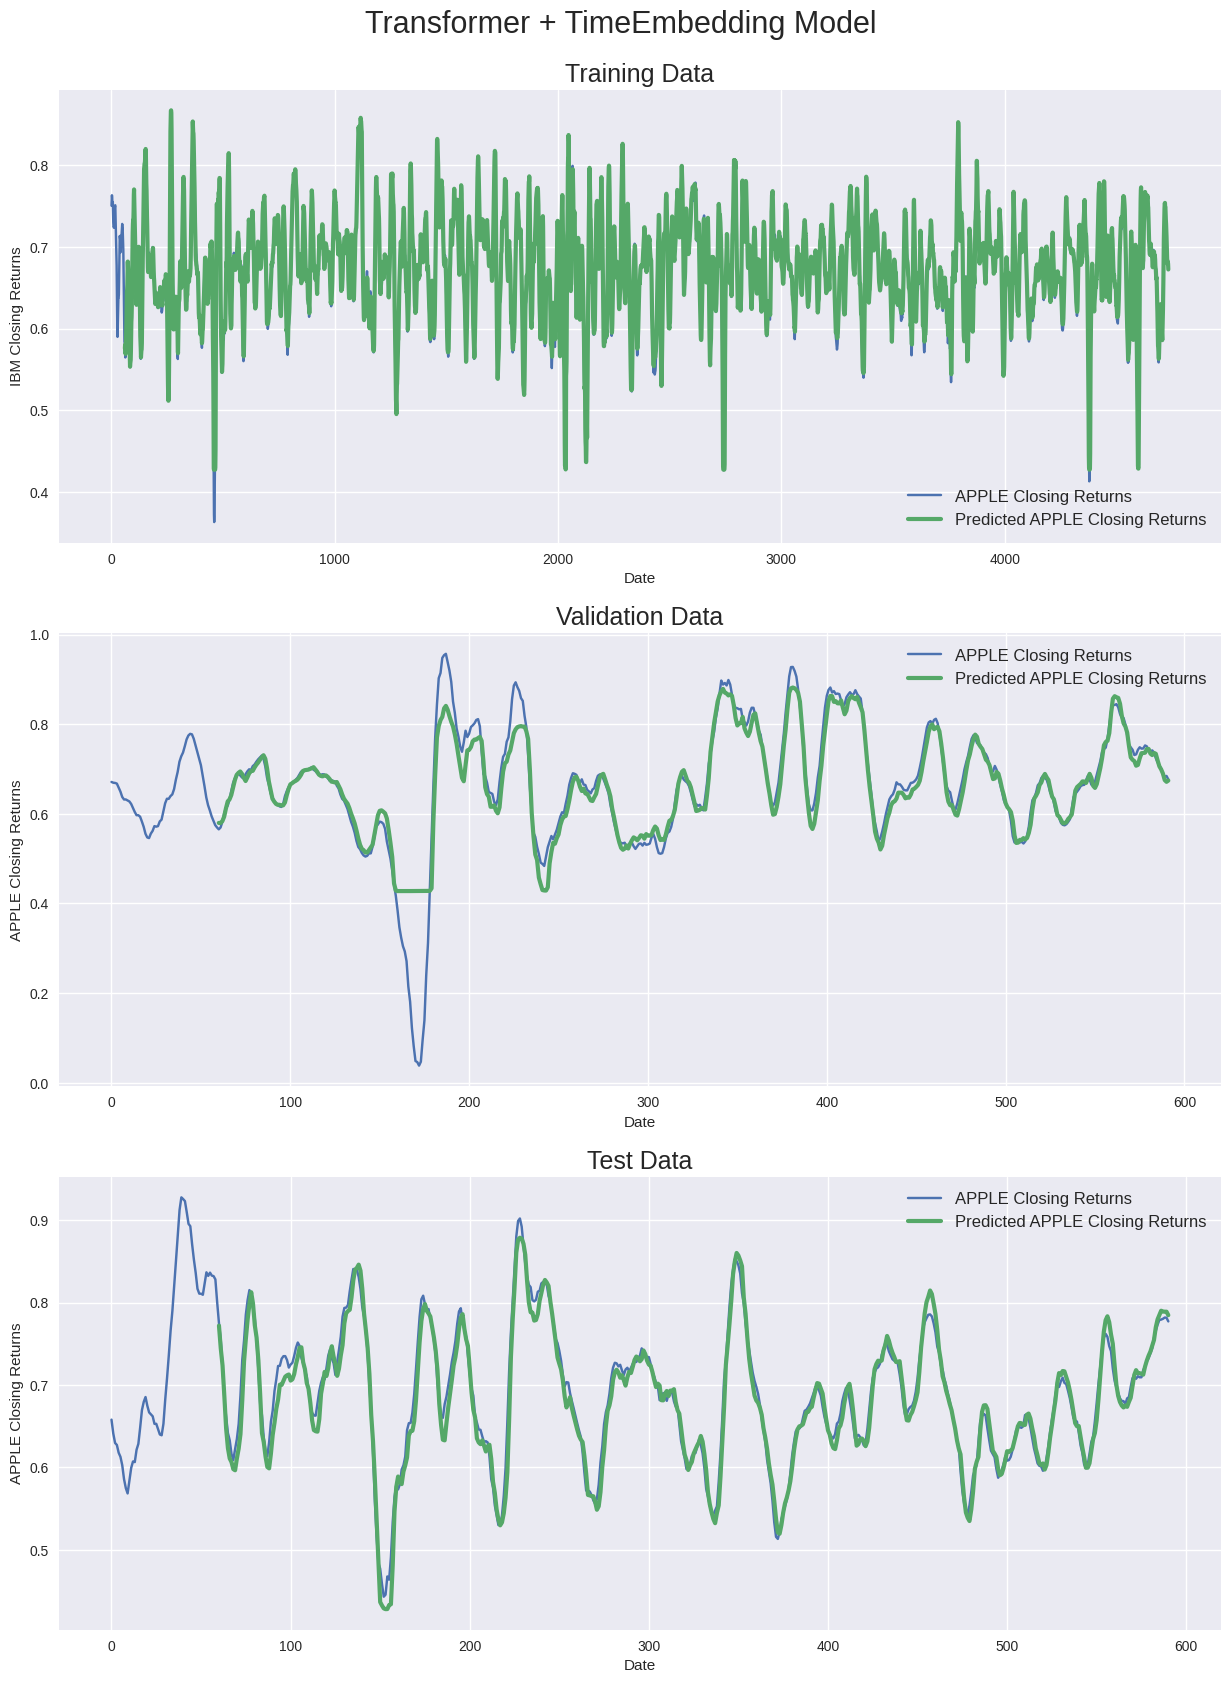

In [ ]:
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='APPLE Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted APPLE Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='APPLE Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted APPLE Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('APPLE Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='APPLE Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted APPLE Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('APPLE Closing Returns')
ax31.legend(loc="best", fontsize=12)


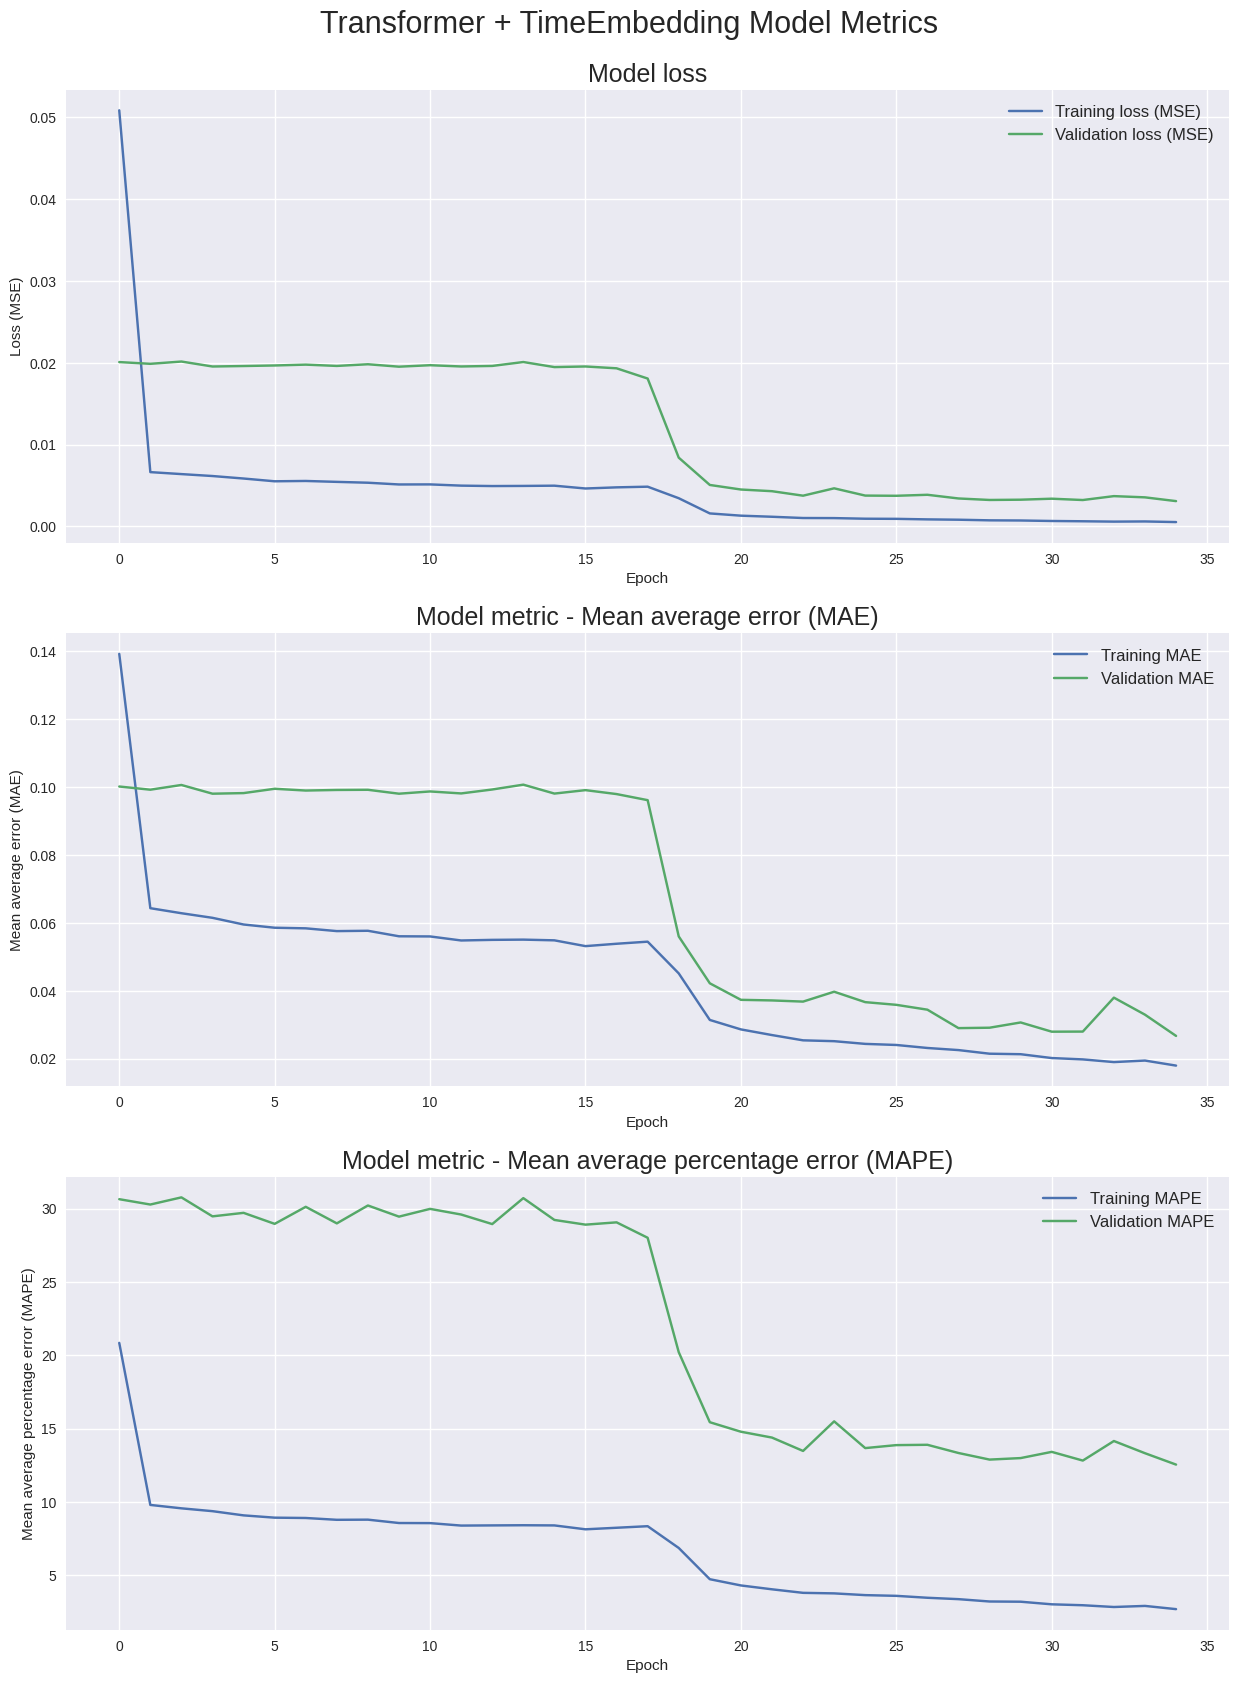

In [ ]:
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)